In [1]:
import h5py

# load dataset
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']
labels = dataset['labels']

<KeysViewHDF5 ['images', 'labels']>


(64, 64, 3)


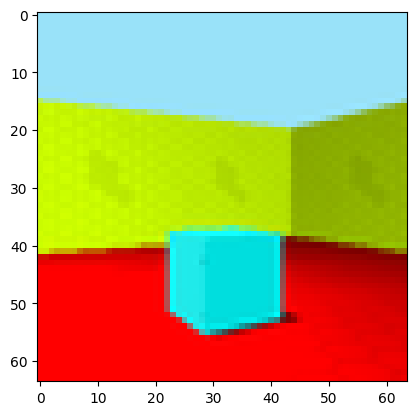

In [2]:
img = images[12000]
print(img.shape)

from matplotlib import pyplot as plt

plt.imshow(img)
plt.show()

In [3]:
from module import NFModule

flow = NFModule.load_from_checkpoint('/home/miyashita21/gitrepo/3dshapes/checkpoints/flow/best-epoch=2799-val_loss=-753.3038.bak.ckpt').cuda()

/home/miyashita21/gitrepo/3dshapes/venv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/miyashita21/gitrepo/3dshapes/venv/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have ha

RuntimeError: Error(s) in loading state_dict for NFModule:
	size mismatch for autoencoder.encoder.0.weight: copying a param with shape torch.Size([6, 3, 2, 2]) from checkpoint, the shape in current model is torch.Size([6, 3, 4, 4]).
	size mismatch for autoencoder.encoder.3.weight: copying a param with shape torch.Size([12, 6, 2, 2]) from checkpoint, the shape in current model is torch.Size([12, 6, 4, 4]).
	size mismatch for autoencoder.encoder.6.weight: copying a param with shape torch.Size([24, 12, 2, 2]) from checkpoint, the shape in current model is torch.Size([24, 12, 4, 4]).
	size mismatch for autoencoder.encoder.9.weight: copying a param with shape torch.Size([48, 24, 2, 2]) from checkpoint, the shape in current model is torch.Size([48, 24, 4, 4]).
	size mismatch for autoencoder.encoder.12.weight: copying a param with shape torch.Size([96, 48, 2, 2]) from checkpoint, the shape in current model is torch.Size([96, 48, 4, 4]).
	size mismatch for autoencoder.encoder.15.weight: copying a param with shape torch.Size([128, 96, 2, 2]) from checkpoint, the shape in current model is torch.Size([192, 96, 2, 2]).
	size mismatch for autoencoder.encoder.15.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for autoencoder.decoder.0.weight: copying a param with shape torch.Size([128, 96, 2, 2]) from checkpoint, the shape in current model is torch.Size([192, 96, 2, 2]).
	size mismatch for autoencoder.decoder.3.weight: copying a param with shape torch.Size([96, 48, 2, 2]) from checkpoint, the shape in current model is torch.Size([96, 48, 4, 4]).
	size mismatch for autoencoder.decoder.6.weight: copying a param with shape torch.Size([48, 24, 2, 2]) from checkpoint, the shape in current model is torch.Size([48, 24, 4, 4]).
	size mismatch for autoencoder.decoder.9.weight: copying a param with shape torch.Size([24, 12, 2, 2]) from checkpoint, the shape in current model is torch.Size([24, 12, 4, 4]).
	size mismatch for autoencoder.decoder.12.weight: copying a param with shape torch.Size([12, 6, 2, 2]) from checkpoint, the shape in current model is torch.Size([12, 6, 4, 4]).
	size mismatch for autoencoder.decoder.15.weight: copying a param with shape torch.Size([6, 3, 2, 2]) from checkpoint, the shape in current model is torch.Size([6, 3, 4, 4]).

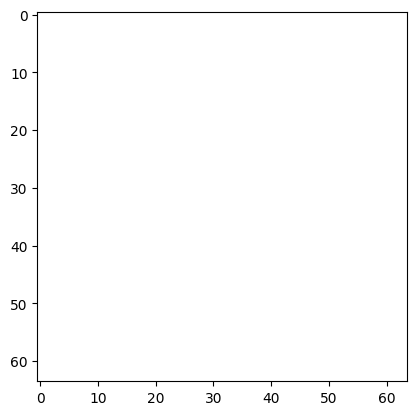

In [4]:
import torch
z = torch.randn(1, 128).cuda()
x = flow.decode(z)

plt.imshow(x[0].clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy())
plt.show()

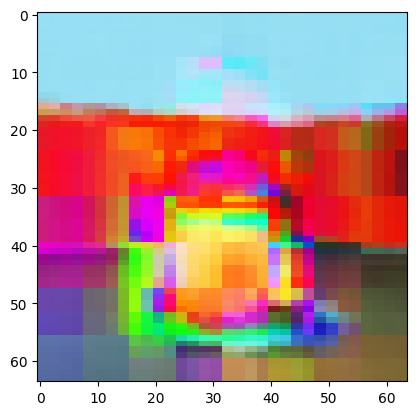

In [5]:
import torch
x = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0
z = flow.encode(x)

n = z.size(-1)
W = torch.randn(n, n).cuda() / 100
W = W - W.t()
W = torch.matrix_exp(W)
z = z @ W

recon_x = flow.decode(z)

plt.imshow(recon_x[0].clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy())
plt.show()

In [6]:
from module import PredictorModule

predictor = PredictorModule.load_from_checkpoint('/home/miyashita21/gitrepo/3dshapes/checkpoints/predictor/best-epoch=732-val_loss=0.9436.ckpt').cuda()

In [7]:
z.size()

torch.Size([1, 128])

In [8]:
from torch.func import vmap, jacrev

def func(z):
    z = z.unsqueeze(0)
    x = flow.decode(z)
    color, scale, shape, orientation = predictor.forward(x)
    return color.squeeze(0), scale.squeeze(0), shape.squeeze(0), orientation.squeeze(0)

jacrev_func = vmap(jacrev(func))

z = flow.encode(x)
color, scale, shape, orientation = jacrev_func(z)

print('color:', color.shape, color.max(), color.min())
print('scale:', scale.shape, scale.max(), scale.min())
print('shape:', shape.shape, shape.max(), shape.min())
print('orientation:', orientation.shape, orientation.max(), orientation.min())

color: torch.Size([1, 3, 2, 128]) tensor(590433., device='cuda:0', grad_fn=<MaxBackward1>) tensor(-326043.5312, device='cuda:0', grad_fn=<MinBackward1>)
scale: torch.Size([1, 1, 128]) tensor(36493.5781, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-73914.5078, device='cuda:0', grad_fn=<MinBackward1>)
shape: torch.Size([1, 4, 128]) tensor(29360.9766, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-34254.1953, device='cuda:0', grad_fn=<MinBackward1>)
orientation: torch.Size([1, 128]) tensor(58229.9492, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-62410.5664, device='cuda:0', grad_fn=<MinBackward1>)


/home/miyashita21/gitrepo/3dshapes/venv/lib/python3.10/site-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [9]:
from dataset import Dataset3DShapes

# load dataset
dataset = h5py.File('3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images'][:]
labels = dataset['labels'][:]
indices = torch.arange(len(images))


<KeysViewHDF5 ['images', 'labels']>


In [20]:
train_dataset = Dataset3DShapes(images, labels, indices)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=400, shuffle=False, num_workers=1)

In [61]:
from cayley import orthogonalize
from cayley_adam import CayleyAdam

k = 256
n = 128

W = orthogonalize(torch.randn(k, n*n))
W = torch.nn.Parameter(W.cuda())
optimizer = CayleyAdam([W], lr=1e-4)

In [62]:
def _mono_weights(k: int, dtype, device, strength: float = 0.5) -> torch.Tensor:
    # 非増加 w1>=...>=wk を平均1に正規化（strength=0で等重み＝順序付け無効）
    w = torch.linspace(1.0 + strength*(k-1), 1.0, steps=k, dtype=dtype, device=device)
    return w / w.sum() * k

mono_weights = _mono_weights(k, dtype=W.dtype, device=W.device, strength=0.5)

In [64]:
from tqdm import tqdm


epochs = 10

for epoch in range(epochs):
    pbar = tqdm(train_dataloader)
    pbar.set_description(f'Epoch {epoch+1}/{epochs}')
    for batch in pbar:
        imgs, *lbls = batch
        imgs = imgs.cuda()
        
        with torch.no_grad():
            z = flow.encode(imgs)
            color, scale, shape, orientation = jacrev_func(z)
        scale = scale.squeeze(1)

        W_unflat = W.view(k, n, n)
        W_unflat = W_unflat - W_unflat.transpose(1, 2)

        l_scale = torch.einsum('bi,kij,bj->bk', scale, W_unflat, z)
        l_shape = torch.einsum('bci,kij,bj->bck', shape, W_unflat, z)

        scale_loss = l_scale.square().mul(mono_weights).mean()
        shape_loss = l_shape.square().mul(mono_weights).mean()

        loss = scale_loss + shape_loss
        loss = loss / 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({'loss': loss.item(), 'scale_loss': scale_loss.item(), 'shape_loss': shape_loss.item()})

    pbar.reset()


Epoch 1/10:   0%|          | 0/1200 [00:00<?, ?it/s]/home/miyashita21/gitrepo/3dshapes/cayley_adam.py:316: UserWarning: `torch._utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  if not torch._utils.is_compiling() and not all(isinstance(t, torch.Tensor) for t in state_steps):
/home/miyashita21/gitrepo/3dshapes/cayley_adam.py:474: UserWarning: `torch._utils.is_compiling` is deprecated. Use `torch.compiler.is_compiling` instead.
  if not torch._utils.is_compiling() and capturable:
Epoch 10/10: 100%|██████████| 1200/1200 [01:41<00:00, 11.88it/s, loss=0.000466, scale_loss=0.000318, shape_loss=0.000615]


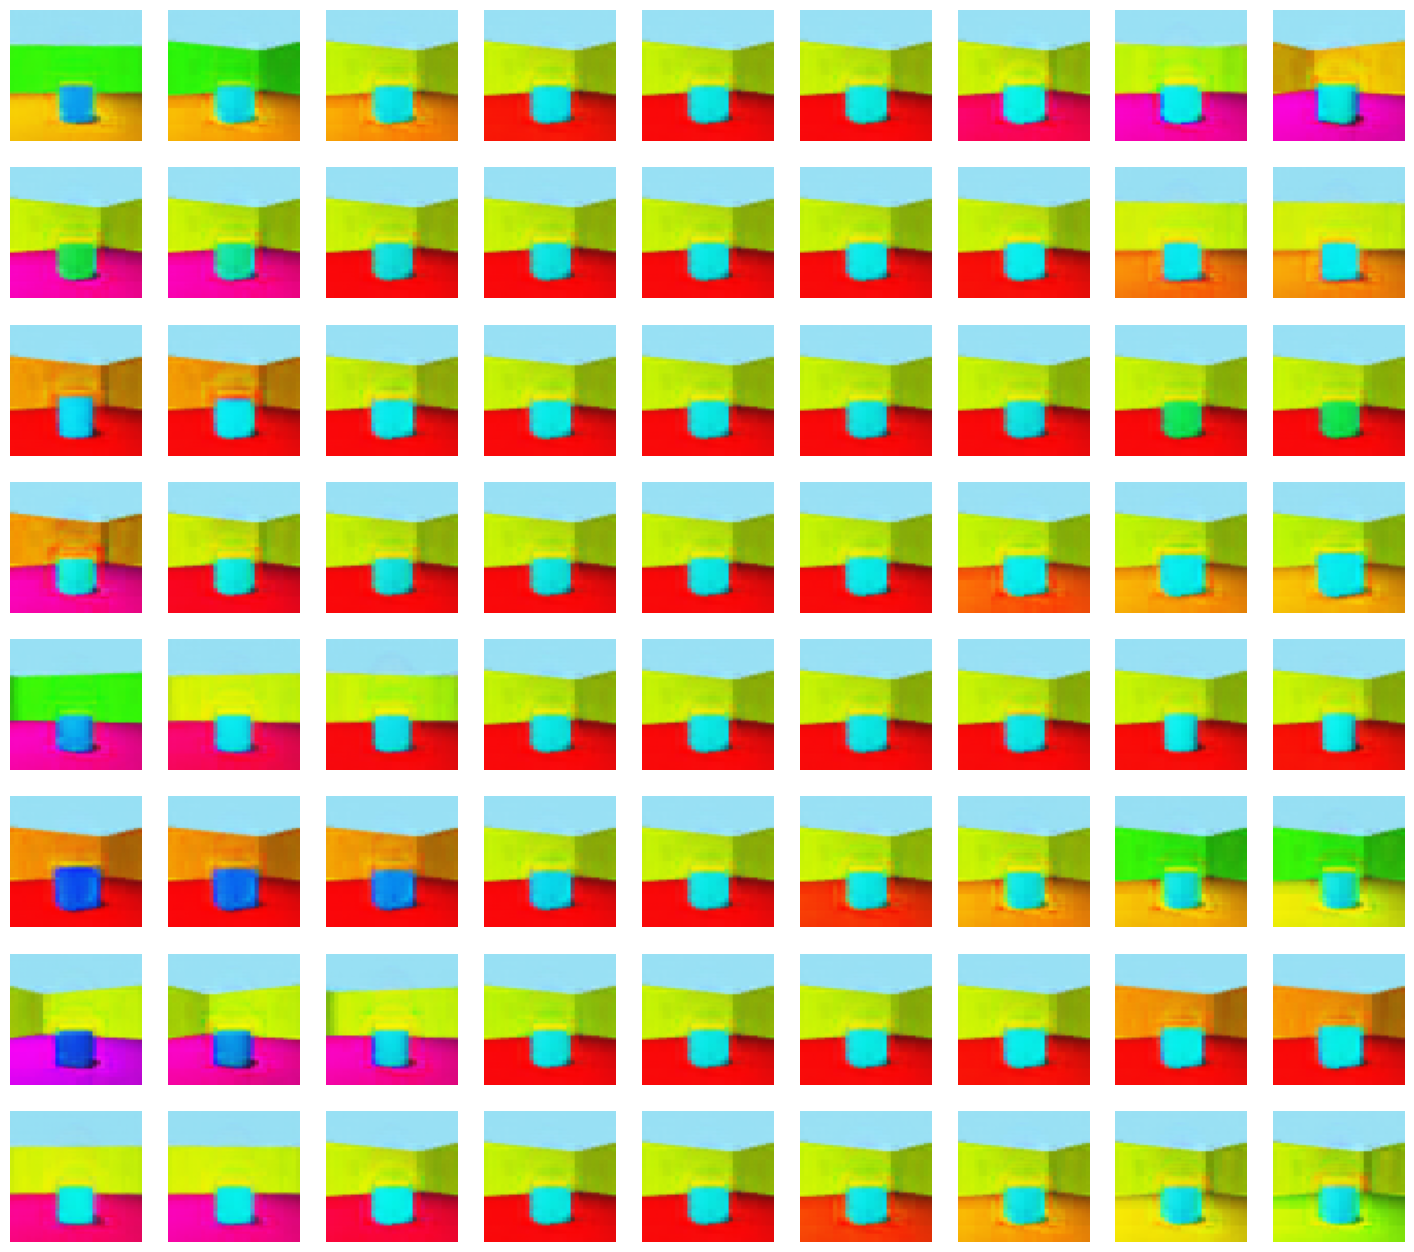

In [73]:
import torch
img = images[12000]
x = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0
z = flow.encode(x)

n = z.size(-1)

w = W[:8].view(8, 1, n, n)
t = torch.linspace(-8, 8, 9).cuda().view(-1, 1, 1)
w = torch.matrix_exp(t*w)
w = w.view(-1, n, n)
z = w @ z.unsqueeze(-1)
z = z.squeeze(-1)

recon_x = flow.decode(z)

recon_x = recon_x.view(8, 9, 3, 64, 64)

fig, axes = plt.subplots(8, 9, figsize=(18, 16))

for i in range(8):
    for j in range(9):
        axes[i, j].imshow(recon_x[i, j].clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy())
        axes[i, j].axis("off")

plt.show()

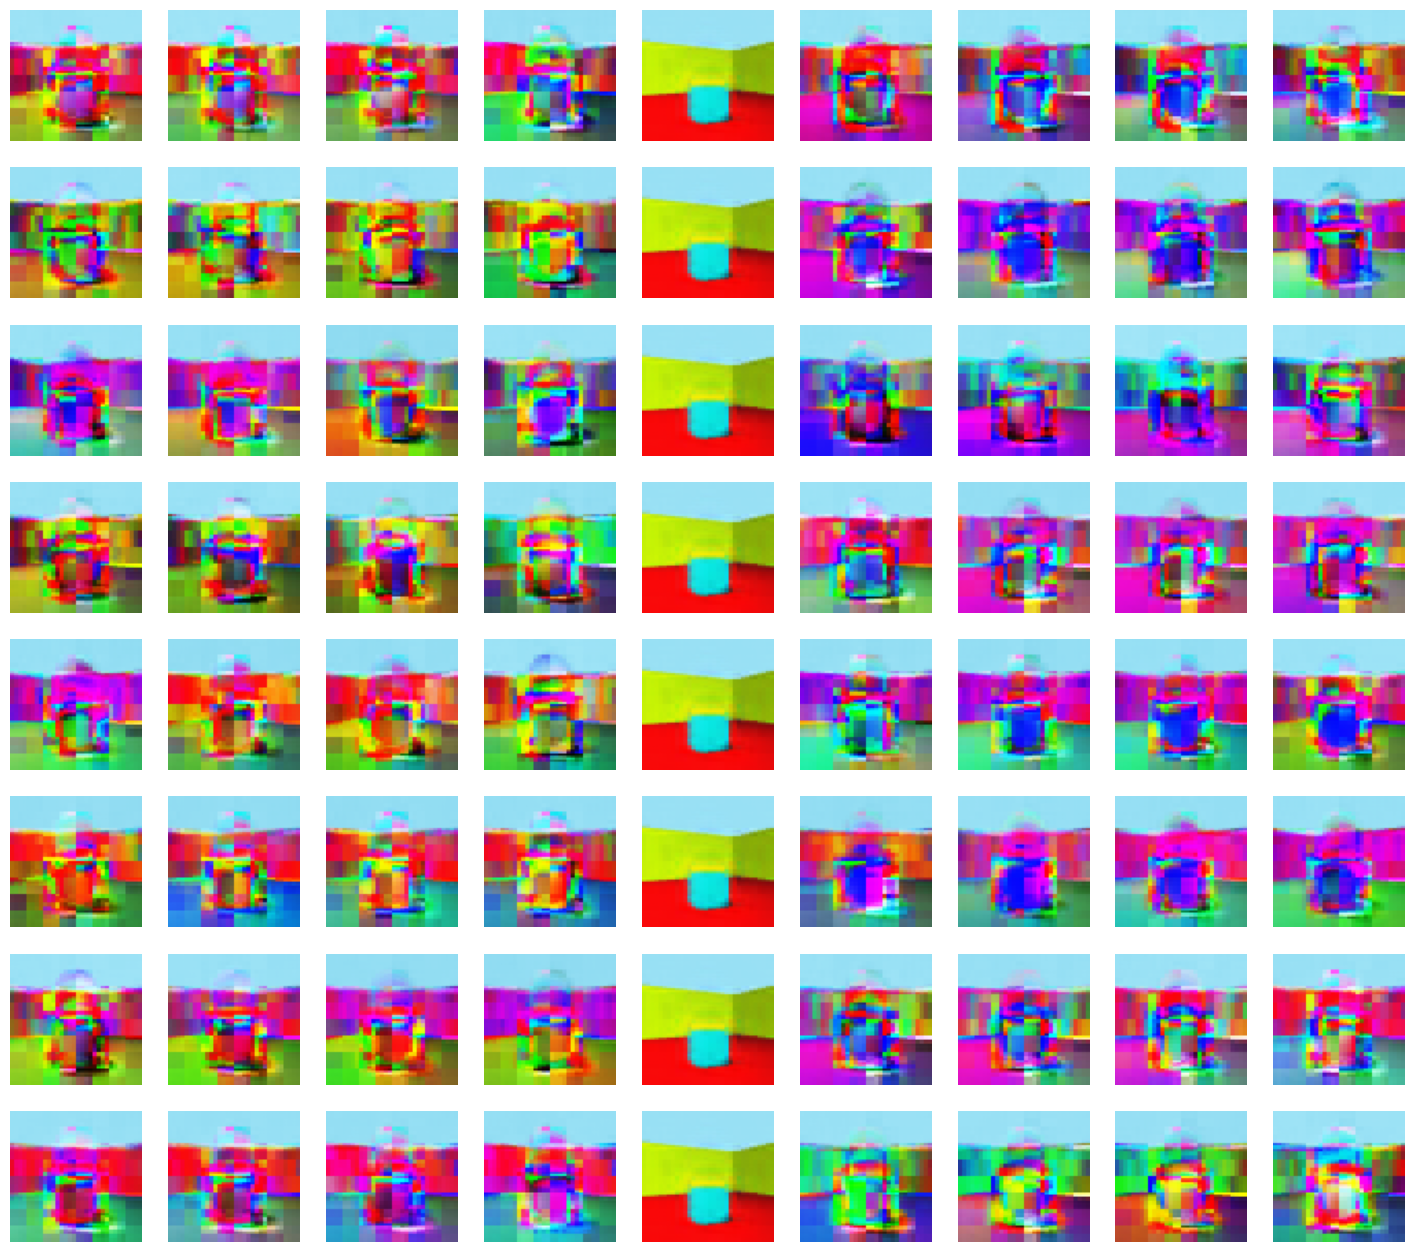

In [10]:
import torch
img = images[12000]
x = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().cuda() / 255.0
z = flow.encode(x)

n = z.size(-1)

w = torch.randn(8, 1, n, n).cuda() / n * 2
w = w - w.transpose(-1, -2)
t = torch.linspace(-8, 8, 9).cuda().view(-1, 1, 1)
w = torch.matrix_exp(t*w)
w = w.view(-1, n, n)
z = w @ z.unsqueeze(-1)
z = z.squeeze(-1)

recon_x = flow.decode(z)

recon_x = recon_x.view(8, 9, 3, 64, 64)

fig, axes = plt.subplots(8, 9, figsize=(18, 16))

for i in range(8):
    for j in range(9):
        axes[i, j].imshow(recon_x[i, j].clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy())
        axes[i, j].axis("off")

plt.show()

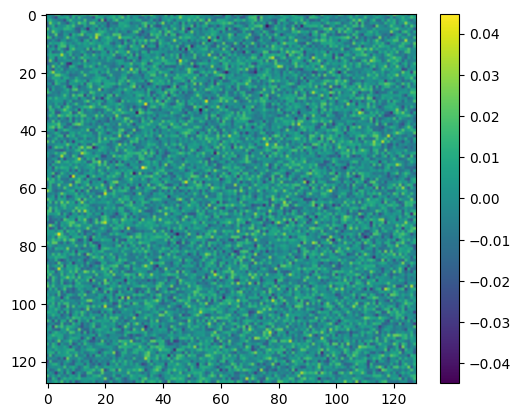

In [67]:
w = W[0].view(n, n)
w = w - w.t()
plt.imshow(w.detach().cpu().numpy())
plt.colorbar()
plt.show()

Text(0.5, 0, 'Index of generator')

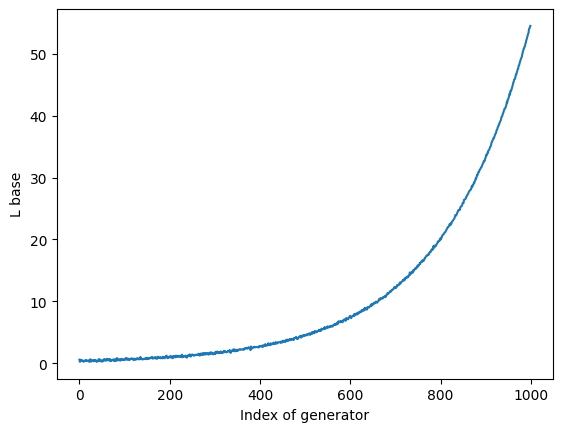

In [13]:
from matplotlib import pyplot as plt
import torch

x = torch.linspace(-1, 4, 1000).exp()
x = x + torch.randn_like(x) * 0.1
plt.plot(x.detach().cpu().numpy())

plt.ylabel('L base')
plt.xlabel('Index of generator')
